C:\Users\conno\AppData\Local\conda\conda\envs\group_project\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0282666643461 Minutes


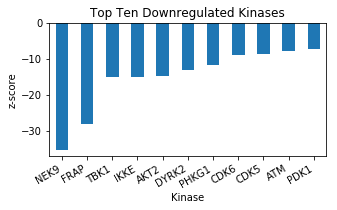

In [6]:
import time

start = time.time()

import pandas as pd 
import csv
import matplotlib as mat # graphs 
import matplotlib.pyplot as plt # graphs
import psycopg2 as pg # database connection
import pandas.io.sql as psql # the accomplise (turns queries into dataframes)
import numpy as np # converts nans
import math # for log2

input_file = "az20.tsv" # this is where the upload button should be linked to 

names = []
residuelist = []
kinase = []
fclist = []

with open(input_file, "r") as data:
    data = csv.reader(data, delimiter='\t')
    next(data, None)
    for row in data:
        data = row[0:6]
        if "(" in data[0]:
            name = data[0].split("(")[0]
            residue1 = data[0].split("(")[1]
            residue = residue1.split(")")[0]
            fc = data[3] # the above formats the raw data correctly
        else:
            pass # if there is no residue it skips
        if "_" in name: 
            name = name.split("_")[0]  # takes away _HUMAN
        if residue != "None":
            if residue != "inf": # removes useless data
                names.append(name)
                residuelist.append(residue)
                fclist.append(fc) # all into separate lists

df2 = pd.DataFrame()
df2["gene"] = names
df2["residue"] = residuelist
df2["fold_change"] = fclist # turns into datafram          
            
genename = names
location = residuelist # variables

connection = pg.connect("dbname=d71uh4v1fd2hq user=tdsneouerzmxkj \
password=92a500cb091fe70168b32c66fa6a3d6c376d467d57fb9b663eb5d13446ecb2e6 \
host=ec2-54-75-245-94.eu-west-1.compute.amazonaws.com")

cur = connection.cursor()

result = cur.execute('SELECT "KINASE_NAME", "GENE_NAME", "RESIDUE" FROM public."Phosphosite_table" WHERE \
            "GENE_NAME" LIKE any(%s) and "RESIDUE" LIKE any(%s)',
            (genename, location)) # uses variables to extract data

df = pd.DataFrame(cur.fetchall())
df.columns = ['kinase', 'gene', 'residue'] # puts query into df

connection.close()

result = pd.merge(df,df2, on = ('gene','residue'), how = "left") # compares query result and raw data input and creates a\
# new df of the matches 

result['fold_change'].dropna()
d = result.replace("inf", np.nan)
e = d.replace("0", np.nan)
f = e.replace("", np.nan)
new = f.dropna(how='all') # data cleaning 
df3 = new.dropna()
log2 = []
for row in df3.itertuples(): # iterates through list
    name = row[1]
    residue = row [2]
    kinase = row[3]
    fc = float(row[4])
    twoval = math.log(fc, 2) # performs log2 on the fold change 
    log2.append(twoval)
    
df3["log2(fc)"] = log2 # appended into df

total = {}

for row in df3.itertuples():
    name = row[2]
    residue = row [3]
    kinase = row[1]
    fc = float(row[4])
    log2fc = float(row[5])
    if kinase == kinase: # this creates a dictionary with the key as the kinase; the phosphosites of said kinase is appened \
        # to a dictionary with the kinases as keys
        if kinase in total:
            total[kinase].append(log2fc)
        else:
            total[kinase] = [log2fc] # this just catches an error out. 

newdict = {}

for key, value in total.iteritems():
    s = sum(value)/len(value)
    newdict[key] = s # the mean of the substrates are found and put into new dictionary 
    
rdf = pd.read_csv(input_file, sep="\t")     
nrdf = rdf.iloc[:,0:4]
new = nrdf.replace(0, np.nan)
new = new.dropna(how='all')
new = new.dropna() # cleans input data from raw file again straight into pandas 

another = []

for d in new.itertuples():
    fc = str(d[4])
    if fc != 'inf':
        fc = math.log(float(fc), 2)
        another.append(fc)  #this calculates the log2 of all fcs in our sample (s)
        
p = sum(another)/len(another) # this finds the mean

m = math.sqrt(len(df3.index)) #this finds the square root of the number of substrates identified to a kinase 

s = np.std(another) # this finds the standard deviation from the sample 

score = {}

for key, value in newdict.iteritems():
    val = ((value - p)*m)/float(s)
    score[key] = val # this appends the z-score with the kinases as the key 

# putting values into a pandas df    
    
final = pd.DataFrame(score.items())
final.columns = ["Kinase", "z-score"] # appends from diction into a pandas dataframe 

# putting kinases in order from lowest to highest z-score

organised = final.sort_values(['z-score'], ascending = True) # organises list from the lowest to highest z-score

# indexing top ten z-scores

top10 = organised.iloc[0:11,:] # takes the top ten results 

# putting values into a bar graph

ax = top10.plot.bar(x = "Kinase", rot=0, figsize=(7,3.5))

# adjusting figure size

plt.subplots_adjust(bottom=0.35, left=0.35)

# setting title

ax.set_title('Top Ten Downregulated Kinases')

# removing figure legend

ax.get_legend().remove()

# setting y-label

ax.set_ylabel('z-score')

# adjusting x-axis labels to be more visible

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# converts into figure

fig = ax.get_figure()

# saves figure

fig.savefig('topten' + '(' + input_file + ')' + '.png')

# saves data into csv files

organised.to_csv('total_list' + '(' + input_file + ')' + '.csv')
top10.to_csv('topten_list' + '(' + input_file + ')' + '.csv')
            
end = time.time()

print str((end - start)/60) + " Minutes" # prints the amount of time the code took to run

In [3]:
print final

           0          1
0       JNK1  -3.111707
1       JNK2   6.918882
2       PLK1  -0.333508
3       PLK3   8.056438
4        ATM  -7.815351
5      HIPK2   4.054556
6       AKT2 -14.781281
7      DYRK2 -13.151869
8       P38B   4.383730
9       P38A  -0.737443
10      PKG1  -1.033973
11      ABL1   7.959709
12      RSK1  -3.620094
13  MAPKAPK5   4.090142
14  MAPKAPK3   7.384455
15  MAPKAPK2   2.084996
16      NEK6  -1.501235
17      MSK1   1.864129
18     CK2A1   0.055027
19      TBK1 -15.067988
20      SGK3  -2.087498
21       FYN  12.477742
22       ACK  -0.686520
23      NEK9 -35.268013
24      IKKE -15.067988
25       FAK  -0.686520
26      AKT1  -4.301511
27      AURA   4.706129
28     MARK2  -1.740362
29      IKKB  -5.564603
..       ...        ...
47      PKCD  -0.752334
48      FRAP -28.102156
49      ERK4   9.396977
50      CDC2   1.594720
51      RSK2  -2.087498
52      WEE1   1.215496
53      CK1A   5.430287
54      ERK1   2.095395
55      ERK2   3.630755
56      ERK3  10